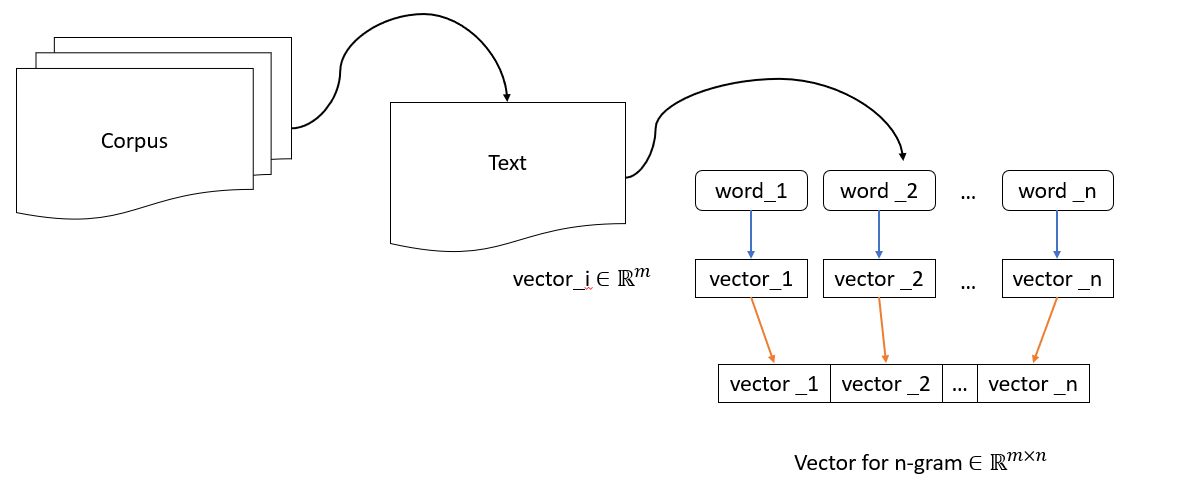

In [32]:
import numpy as np
from collections import defaultdict
import os
import gc
import re

In [ ]:
# Word embeddings
slv_word_dict = np.load('slv_cbow_norm_dictionary.npy', allow_pickle=True).item()

# Slovenian bigrams

Parameters:

*   min_count - frequency of bigram in the corpus
*   min_text_count - frequency of bigram per texts in the corpus (DF)


In [ ]:
def get_bigram_concat(dictionary, corpus_path, min_count, min_text_count, lang_prefix="", m=100):
    # Track stats
    bigram_stats = defaultdict(lambda: {'total_count': 0, 'text_count': 0})
    vocab = set(dictionary.keys())

    # First collect stats within corpus
    with open(corpus_path, 'r', encoding='utf-8') as f:
        for line in f:
            words = line.strip().split()
            seen_in_line = set()  # current line

            for i in range(len(words)-1):
                word1, word2 = words[i], words[i+1]
                if word1 not in vocab or word2 not in vocab:
                    continue

                bigram = f"{word1} {word2}"
                bigram_stats[bigram]['total_count'] += 1

                if bigram not in seen_in_line:
                    bigram_stats[bigram]['text_count'] += 1
                    seen_in_line.add(bigram)

    # Only for frequent bigrams
    bigram_dict = {}
    for bigram, stats in bigram_stats.items():
        if stats['total_count'] >= min_count and stats['text_count'] >= min_text_count:
            word1, word2 = bigram.split()
            # Concatenate vectors
            vec = np.concatenate((dictionary[word1][:m], dictionary[word2][:m]))
            bigram_dict[bigram] = vec


    suffix = f"_min{min_count}_df"
    np.save(f"{lang_prefix}bigram{suffix}_dictionary.npy", bigram_dict)
    np.save(f"{lang_prefix}bigram{suffix}_embeddings.npy", np.array(list(bigram_dict.values())))

    print(f"{len(bigram_dict)} bigrams (min_count={min_count}, min_text_count={min_text_count})")
    return bigram_dict, np.array(list(bigram_dict.values()))

Filter:

*   skip bigrams with 'person1', 'number1', 'proper1'
*   min_len - minimum chars in the word



In [ ]:
def filter_bigrams(bigram_dict, bigram_vectors, min_len=3, mode='either'):
    # Substituted while lemmatization tokens
    spec_tokens = {'person1', 'number1', 'proper1'}
    filtered_dict = {}
    filtered_indices = []

    for i, (bigram, vec) in enumerate(bigram_dict.items()):
        w1, w2 = bigram.split()

        # Skip if either is in
        if w1 in spec_tokens or w2 in spec_tokens:
            continue

        # Length filtering
        if mode == 'either':
            keep = len(w1) >= min_len and len(w2) >= min_len
        elif mode == 'both':
            keep = not (len(w1) < min_len and len(w2) < min_len)

        if keep:
            filtered_dict[bigram] = vec
            filtered_indices.append(i)

    filtered_vectors = bigram_vectors[filtered_indices]
    return filtered_dict, filtered_vectors

In [ ]:
# 10 3
slv_bigram_dict, slv_bigram_embeddings = get_bigram_concat(slv_word_dict, "filtered_slovenian_corpus.txt", 10, 3, lang_prefix="slv_")

596345 bigrams (min_count=10, min_text_count=3)


In [ ]:
# 10 5
slv_bigram_dict_sm, slv_bigram_embeddings_sm = get_bigram_concat(slv_word_dict, "filtered_slovenian_corpus.txt", 10, 5, lang_prefix="slv_")

583799 bigrams (min_count=10, min_text_count=5)


In [ ]:
# 10 5 _ 3
slv_bigram_dict_sm_filter, slv_bigram_embeddings_sm_filter = filter_bigrams(slv_bigram_dict_sm, slv_bigram_embeddings_sm, mode='either')
print(len(slv_bigram_dict_sm_filter), len(slv_bigram_embeddings_sm_filter))

326394 326394


In [ ]:
# 10 5 _ 4
slv_bigram_dict_sm_filter_4, slv_bigram_embeddings_sm_filter_4 = filter_bigrams(slv_bigram_dict_sm, slv_bigram_embeddings_sm, 4, mode='either')
print(len(slv_bigram_dict_sm_filter_4), len(slv_bigram_embeddings_sm_filter_4))

231308 231308


Set additional parameter:

*   min_count - frequency of bigram in the corpus
*   min_text_count - frequency of bigram per texts in the corpus (DF)
*   frequency of words in bigram -  frequency word in the corpus




In [ ]:
def get_bigram_concat_freq(dictionary, corpus_path, min_count, min_text_count, min_word_freq, lang_prefix="", m=100):
    # Track stats
    word_stats = defaultdict(int)
    vocab = set(dictionary.keys())

    # First collect stats within corpus
    with open(corpus_path, 'r', encoding='utf-8') as f:
        for line in f:
            for word in line.strip().split():
                if word in vocab:
                    word_stats[word] += 1

    # Get words that appear less than min_word_freq
    frequent_words = {word for word, count in word_stats.items() if count >= min_word_freq}

    # Only for bigrams of frequent words
    bigram_stats = defaultdict(lambda: {'total_count': 0, 'text_count': 0})

    with open(corpus_path, 'r', encoding='utf-8') as f:
        for line in f:
            words = line.strip().split()
            seen_in_line = set()  # current line

            for i in range(len(words)-1):
                word1, word2 = words[i], words[i+1]

                # Skip if any word not in frequent
                if word1 not in frequent_words or word2 not in frequent_words:
                    continue

                bigram = f"{word1} {word2}"
                bigram_stats[bigram]['total_count'] += 1

                if bigram not in seen_in_line:
                    bigram_stats[bigram]['text_count'] += 1
                    seen_in_line.add(bigram)

    # Only for frequent bigrams
    bigram_dict = {}
    for bigram, stats in bigram_stats.items():
        if stats['total_count'] >= min_count and stats['text_count'] >= min_text_count:
            word1, word2 = bigram.split()
            vec = np.concatenate((dictionary[word1][:m], dictionary[word2][:m]))
            bigram_dict[bigram] = vec


    suffix = f"_min{min_count}_df_wordfreq{min_word_freq}"
    np.save(f"{lang_prefix}bigram{suffix}_dictionary.npy", bigram_dict)
    np.save(f"{lang_prefix}bigram{suffix}_embeddings.npy", np.array(list(bigram_dict.values())))

    print(f"{len(bigram_dict)} bigrams (min_count={min_count}, min_text_count={min_text_count}, min_word_freq={min_word_freq})")
    return bigram_dict, np.array(list(bigram_dict.values()))

In [ ]:
# 10 5 5
slv_bigram_dict, slv_bigram_embeddings = get_bigram_concat_freq(slv_word_dict, "filtered_slovenian_corpus.txt", 10, 5, 5, lang_prefix="slv_")

583799 bigrams (min_count=10, min_text_count=5, min_word_freq=5)


In [ ]:
# 10 5 15
slv_bigram_dict, slv_bigram_embeddings = get_bigram_concat_freq(slv_word_dict, "filtered_slovenian_corpus.txt", 10, 5, 15, lang_prefix="slv_")

583350 bigrams (min_count=10, min_text_count=5, min_word_freq=15)


In [ ]:
# 15 5 15
slv_bigram_dict, slv_bigram_embeddings = get_bigram_concat_freq(slv_word_dict, "filtered_slovenian_corpus.txt", 15, 5, 15, lang_prefix="slv_")

401318 bigrams (min_count=15, min_text_count=5, min_word_freq=15)


In [ ]:
slv_bigram_dict_filter, slv_bigram_embeddings_filter = filter_bigrams(slv_bigram_dict, slv_bigram_embeddings, 4, mode='either')
print(len(slv_bigram_dict_filter), len(slv_bigram_embeddings_filter))

231217 231217


In [ ]:
slv_bigram_dict_filter, slv_bigram_embeddings_filter = filter_bigrams(slv_bigram_dict, slv_bigram_embeddings, 4, mode='either')
print(len(slv_bigram_dict_filter), len(slv_bigram_embeddings_filter))

147632 147632


# Russian bigrams

In [47]:
# Word embeddings
ru_word_dict = np.load('ru_cbow_norm_dictionary.npy', allow_pickle=True).item()

In [48]:
ru_bigram_dict, ru_bigram_embeddings = get_bigram_concat_freq(ru_word_dict, "cleaned_russian_corpus.txt", 15, 5, 15, lang_prefix="ru_")

150874 bigrams (min_count=15, min_text_count=5, min_word_freq=15)


In [53]:
list(ru_bigram_dict.keys())[:100]

['федорович одоевский',
 'взять карта',
 'параллельный линия',
 'также называть',
 'противоположный сторона',
 'принадлежать также',
 'верно знать',
 'жемчужный раковина',
 'земля жить',
 'разный племя',
 'русский иметь',
 'разный вещь',
 'каждый день',
 'хлопчатый бумага',
 'это растение',
 'варить каша',
 'кушать чай',
 'высекать огонь',
 'очень горький',
 'разный материя',
 'красный краска',
 'синий краска',
 'драгоценный камень',
 'ваш маменька',
 'гостиная весь',
 'видеть очень',
 'очень богатый',
 'очень жаркий',
 'английский купец',
 'высоко сказать',
 'очень ленивый',
 'больший часть',
 'самый главный',
 'носить название',
 'построить храм',
 'очень странный',
 'очень любить',
 'любить сказка',
 'всякий род',
 'древний язык',
 'наш русский',
 'новый сказка',
 'очень смешной',
 'некоторый понятие',
 'бедный пастух',
 'велеть свой',
 'свой жена',
 'идти домой',
 'посмотреть туда',
 'туда сюда',
 'сюда видеть',
 'косить трава',
 'свой корова',
 'любезный друг',
 'сходить домой',
 

In [51]:
ru_bigram_dict_filter, ru_bigram_embeddings_filter = filter_bigrams(ru_bigram_dict, ru_bigram_embeddings, 3, mode='either')
print(len(ru_bigram_dict_filter), len(ru_bigram_embeddings_filter))

150152 150152


In [55]:
ru_bigram_dict_filter, ru_bigram_embeddings_filter = filter_bigrams(ru_bigram_dict, ru_bigram_embeddings, 4, mode='either')
print(len(ru_bigram_dict_filter), len(ru_bigram_embeddings_filter))

135859 135859


In [56]:
list(ru_bigram_dict_filter.keys())[:100]

['федорович одоевский',
 'взять карта',
 'параллельный линия',
 'также называть',
 'противоположный сторона',
 'принадлежать также',
 'верно знать',
 'жемчужный раковина',
 'земля жить',
 'разный племя',
 'русский иметь',
 'разный вещь',
 'каждый день',
 'хлопчатый бумага',
 'варить каша',
 'высекать огонь',
 'очень горький',
 'разный материя',
 'красный краска',
 'синий краска',
 'драгоценный камень',
 'гостиная весь',
 'видеть очень',
 'очень богатый',
 'очень жаркий',
 'английский купец',
 'высоко сказать',
 'очень ленивый',
 'больший часть',
 'самый главный',
 'носить название',
 'построить храм',
 'очень странный',
 'очень любить',
 'любить сказка',
 'древний язык',
 'новый сказка',
 'очень смешной',
 'некоторый понятие',
 'бедный пастух',
 'велеть свой',
 'свой жена',
 'идти домой',
 'посмотреть туда',
 'туда сюда',
 'сюда видеть',
 'косить трава',
 'свой корова',
 'любезный друг',
 'сходить домой',
 'твой услуга',
 'очень благоразумно',
 'малый умный',
 'пушечный выстрел',
 'уби

# Normalize slv

Pipeline: normalize -- PCA -- normalize

In [34]:
if isinstance(slv_bigram_dict_filter, dict):
    embeddings_array = np.stack(list(slv_bigram_dict_filter.values()))
    print(embeddings_array.shape)

(147632, 200)


In [35]:
slv_bigram_embeddings_filter == embeddings_array

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [36]:
# Count length of every vector
lengths = np.linalg.norm(slv_bigram_embeddings_filter, axis=1)

print("Min:", np.min(lengths))
print("Max:", np.max(lengths))
print("Mean:", np.mean(lengths))

tolerance = 1e-6
is_normalized = np.allclose(lengths, 1.0, atol=tolerance)
print("Normalized?", is_normalized)

Min: 1.4142133
Max: 1.4142138
Mean: 1.4142133
Normalized? False


In [66]:
# Normalize
normalized_embeddings = slv_bigram_embeddings_filter / np.linalg.norm(slv_bigram_embeddings_filter, axis=1, keepdims=True)
np.linalg.norm(normalized_embeddings[0])

np.float32(1.0)

In [67]:
keys = list(slv_bigram_dict_filter.keys())
slv_bigram_200_dict = {keys[i]: normalized_embeddings[i] for i in range(len(keys))}

len(slv_bigram_dict_filter), len(slv_bigram_200_dict)

(147632, 147632)

In [68]:
np.save('slv_bigram200_norm_embeddings.npy', normalized_embeddings)
np.save("slv_bigram200_norm_dictionary.npy", slv_bigram_200_dict)

In [41]:
lengths = np.linalg.norm(normalized_embeddings, axis=1)
print("Min:", np.min(lengths), "Max:", np.max(lengths))
slv_bigram_embeddings_filter.shape, normalized_embeddings.shape

Min: 0.9999998 Max: 1.0000001


((147632, 200), (147632, 200))

In [43]:
from sklearn.decomposition import PCA
# Reduce to 100D with PCA
pca = PCA(n_components=100)
slv_bigram_100 = pca.fit_transform(normalized_embeddings)

In [44]:
# Renormalize
slv_bigram_100 = slv_bigram_100 / np.linalg.norm(slv_bigram_100, axis=1, keepdims=True)
slv_bigram_100.shape

(147632, 100)

In [45]:
keys = list(slv_bigram_dict_filter.keys())
slv_bigram_100_dict = {keys[i]: slv_bigram_100[i] for i in range(len(keys))}

len(slv_bigram_dict_filter), len(slv_bigram_100_dict)

(147632, 147632)

In [46]:
np.save('slv_bigram_norm_embeddings.npy', slv_bigram_100)
np.save("slv_bigram_norm_dictionary.npy", slv_bigram_100_dict)

# Normalize ru

In [57]:
if isinstance(ru_bigram_dict_filter, dict):
    embeddings_array = np.stack(list(ru_bigram_dict_filter.values()))
    print(embeddings_array.shape)

(135859, 200)


In [58]:
ru_bigram_embeddings_filter == embeddings_array

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [59]:
# Count length of every vector
lengths = np.linalg.norm(ru_bigram_embeddings_filter, axis=1)

print("Min:", np.min(lengths))
print("Max:", np.max(lengths))
print("Mean:", np.mean(lengths))

tolerance = 1e-6
is_normalized = np.allclose(lengths, 1.0, atol=tolerance)
print("Normalized?", is_normalized)

Min: 1.4142134
Max: 1.4142138
Mean: 1.4142133
Normalized? False


In [69]:
# Normalize
normalized_embeddings = ru_bigram_embeddings_filter / np.linalg.norm(ru_bigram_embeddings_filter, axis=1, keepdims=True)
np.linalg.norm(normalized_embeddings[0])

np.float32(1.0)

In [71]:
keys = list(ru_bigram_dict_filter.keys())
ru_bigram_200_dict = {keys[i]: normalized_embeddings[i] for i in range(len(keys))}

len(ru_bigram_dict_filter), len(ru_bigram_200_dict)

(135859, 135859)

In [72]:
np.save('ru_bigram200_norm_embeddings.npy', normalized_embeddings)
np.save("ru_bigram200_norm_dictionary.npy", ru_bigram_200_dict)

In [70]:
lengths = np.linalg.norm(normalized_embeddings, axis=1)
print("Min:", np.min(lengths), "Max:", np.max(lengths))
ru_bigram_embeddings_filter.shape, normalized_embeddings.shape

Min: 0.9999999 Max: 1.0000001


((135859, 200), (135859, 200))

In [63]:
from sklearn.decomposition import PCA
# Reduce to 100D with PCA
pca = PCA(n_components=100)
ru_bigram_100 = pca.fit_transform(normalized_embeddings)

# Renormalize
ru_bigram_100 = ru_bigram_100 / np.linalg.norm(ru_bigram_100, axis=1, keepdims=True)
ru_bigram_100.shape

(135859, 100)

In [64]:
keys = list(ru_bigram_dict_filter.keys())
ru_bigram_100_dict = {keys[i]: ru_bigram_100[i] for i in range(len(keys))}

len(ru_bigram_dict_filter), len(ru_bigram_100_dict)

(135859, 135859)

In [65]:
np.save('ru_bigram_norm_embeddings.npy', ru_bigram_100)
np.save("ru_bigram_norm_dictionary.npy", ru_bigram_100_dict)